In [2]:
import google.datalab.bigquery as bq
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
%matplotlib inline
plt.show()

# Exploring Average Number of Hospital Visits

### By: Alisha Dhanani, Angelina You, and Kellen Stillman

In our project, we were interested in exploring hospital data. Some of the biggest breakthrough applications for machine learning are to be found in the healthcare industry. Disease identification, personalized treatment, and clinical research are examples among many others in the immense potential applications of machine learning is positioned to benefit the healthcare industry with. As a result, we wanted to use a healthcare database to train a simple network. 
    

## How to use age, total charge, and hcc risk score to predict total hospital visits?

Originally, we were interested in seeing if we could predict revenue generated by the hospital by looking at a variety of factors. A messy healthcare system that revolves around convoluted regulations and ambiguous accounting practices made us want to explore if we could predict revenue generation through insurance charges by looking at a couple of variables we thought would give us the most insight into revenue generated by the hospital. Because the healthcare industry is so obscure in its pricing practices, we wanted to explore a network that could predict revenue generated from hospitals by insurance companies.

We put together a network which we thought had the appropriate architecture and input to accurately predict the hospital data. But, as shown in our disappointing results below, in reality, we put together a very poor performing network that did not estimate revenue with much accuracy. This led us to re-examine our underlying assumptions and we realized that because insurance charges vary so wildly, our model would have trouble predicting the appropriate rates for prediction. For example, both annual checks up and a variety of surgeries are both fairly routine procedures for hospitals but vary immensely in the amount of revenue they generate. Without sufficient data to provide more information on procedure types, we concluded that our network would be very inaccurate and decided to explore a better-suited opportunity. 

The graph shows that our model has very inaccurate prediction. As the loss of the evaluation is always much higher than the loss of the training test.
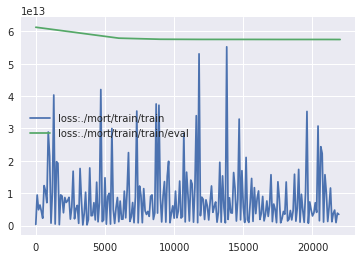

As we realize this problem, we tried to find a more predictive output variables. After research, we discovered that the hopistal visits can be more precisely predicted than the total charge. In real life, people also think the number of hospital visits is important. For instance, insurance companies want to know the customers' hopital visits when selling their products to factor in the health risks of their customers. Therefore, by targeting our predicted value to the total hospital visits, we not only increase our model accuracy, but also provide meaningful information for people in our everyday life.


In [3]:
%%bq tables describe -n "bigquery-public-data.cms_medicare.home_health_agencies_2014"

# Data Preparation
Because our data had a relatively small number of observations at 10882 rows, we decided to pick a slightly higher ratio of training to evaluation data than might otherwise be advisable. We felt that our strong predictor variables would prevent overfitting and wanted to ensure that our model would have plenty of data from which to develop weights from. So, the data was split 90% training and 10% evaluation. This produced training set of 9795 instances and an evaluation set of 1087 instances. 

In [4]:
%%bq query -n mort
SELECT
      average_hcc_score, 
      average_age AS age,
      average_number_of_total_visits_per_episode_non_lupa AS avg_visits,
      total_hha_charge_amount_non_lupa as total_charge
FROM `bigquery-public-data.cms_medicare.home_health_agencies_2014` 

In [5]:
%%bq execute -q mort

average_hcc_score,age,avg_visits,total_charge
2.7,52,13.8,30093
1.76,53,8.5,47820
2.04,54,11.7,103326
2.13,54,15.3,437464
1.88,54,17.9,299074
1.88,56,13.1,265222
1.49,56,15.1,294036
2.32,56,16.2,539053
2.11,56,20.1,325700
2.34,56,21.5,241708


### Export query into dataframe

After we ran the query, we realized that our data size is 10882, which is not very big comparing to some other big queries. In order to ensure we have a sufficiently large training set and testing set, we decided to use the whole dataset insteand of randomly sampling it. As a result, we export the original query to dataframe.

In [6]:
query=mort.execute()
query.result()
df = query.result().to_dataframe()

In [7]:
print(df)

       average_hcc_score  age  avg_visits  total_charge
0                   2.70   52        13.8         30093
1                   1.76   53         8.5         47820
2                   2.13   54        15.3        437464
3                   1.88   54        17.9        299074
4                   2.04   54        11.7        103326
5                   1.88   56        13.1        265222
6                   2.16   56        10.7        532508
7                   1.72   56        15.8        417493
8                   2.32   56        16.2        539053
9                   2.32   56        10.4       1241555
10                  2.34   56        21.5        241708
11                  1.49   56        15.1        294036
12                  2.11   56        20.1        325700
13                  2.62   56        20.4        427201
14                  1.94   57        16.9        662441
15                  1.45   57        14.0        221641
16                  1.70   57        13.5       

### Data Visulization

After we exported the data into dataframe, we explored our data by visulization to have a better understanding of each variables and the relationship between them. As we are interested to predict visits, we use jointplot to see how hcc score,age and,charge related to visits.

From these graphs, we can see none of the variables have a clear linear relationship with visits, but all of these variables have an approximately normal distribution, which means we do not have many significant outliers than influence our predictive model.

/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


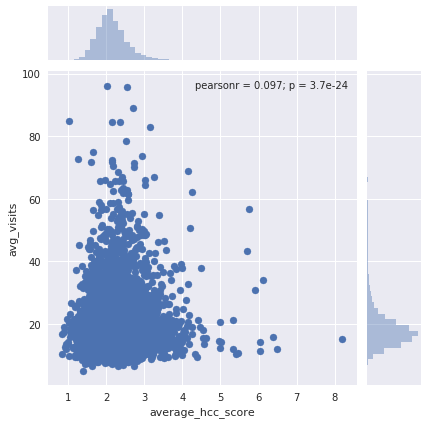

In [8]:
## Data visualization
sns.jointplot(x='average_hcc_score', y='avg_visits', data=df);

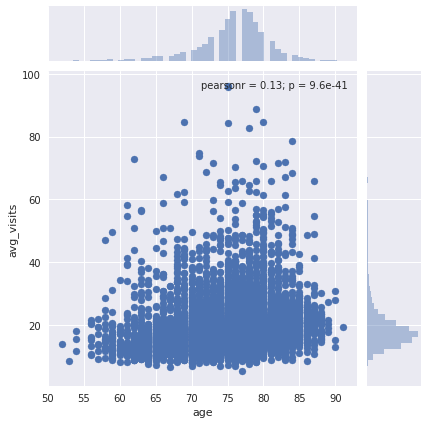

In [9]:
sns.jointplot(x='age', y='avg_visits', data=df);

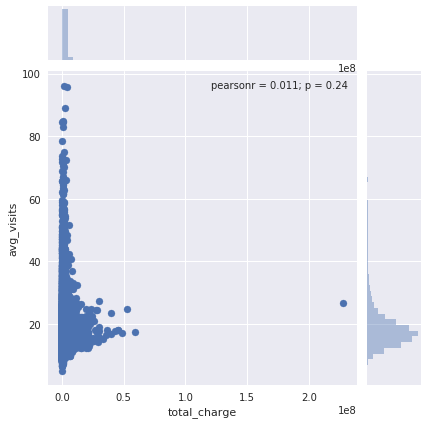

In [10]:
sns.jointplot(x='total_charge', y='avg_visits', data=df);

In [11]:
msk = np.random.rand(len(df)) < 0.9
train_df = df[msk]
eval_df = df[~msk]

In [12]:
print('Training set includes %d instances.' % len(train_df))
print('Eval set includes %d instances.' % len(eval_df))

Training set includes 9813 instances.
Eval set includes 1069 instances.


In [13]:
# Create a directory to store our training data. 
!mkdir -p ./mort

In [14]:
train_df.to_csv('./mort/train.csv', header=False, index=False)
eval_df.to_csv('./mort/eval.csv', header=False, index=False)

# Model Building
In order to build our model, we needed to construct our schema with the specific variable types needed. At first we tried a one layer model with 80 nodes, and got subpar results. In order to better accomodate the variation in average HCC score, age, and average visits. Because of the complexity of our input variables, we added a second hidden layer with 79 nodes. This time around the model produced much better results. 

In [15]:
# This loads %%ml commands
import google.datalab.contrib.mlworkbench.commands

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Create a dataset (data location, schema, train, eval) so we can reference it later.

In [16]:
%%ml dataset create
format: csv
train: ./mort/train.csv
eval: ./mort/eval.csv
name: mort_1pcnt
#schema: $data_schema 
schema:
    - name: average_hcc_score
      type: FLOAT
    - name: age
      type: INTEGER
    - name: avg_visits
      type: FLOAT
    - name: total_charge
      type: INTEGER
          

In [17]:
# Delete previous run results.
!rm -r -f ./mort/analysis 

In [18]:
%%ml analyze
output: ./mort/analysis
data: mort_1pcnt
features: 
  average_hcc_score:
    transform: scale
  age:
    transform: scale
  avg_visits:
    transform: target
  total_charge:
    transform: scale
  

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Expanding any file patterns...
file list computed.
Analyzing file /content/datalab/mort/train.csv...
file /content/datalab/mort/train.csv analyzed.


In [19]:
%%ml dataset explore
name: mort_1pcnt

train data instances: 9813
eval data instances: 1069


In [20]:
!rm -r -f ./mort/train

In [21]:
%%ml train 
output: ./mort/train
analysis: ./mort/analysis
data: mort_1pcnt
model_args:
    model: dnn_regression
    hidden-layer-size1: 80
    hidden-layer-size2: 79

TensorBoard was started successfully with pid 644. Click here to access it.

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [22]:
from google.datalab.ml import Summary

summary = Summary('./mort/train')

# Results
After running the training set through the dnn regression, we were able to produce a model that had a mean square error of 6.5 visits. These results were produced with only 3 predictor variables to assign weights to, yet still it produced a fairly accurate estimate of number of visits. The weighting produced by the dnn regression is on average about six visits off. This is understandable because of the variables we chose; HCC score, age, and average visits. While useful, not all of them necessarily have a direct linear relationships with our target variable of number of visits. However, considering that the dataset likely contained extreme cases of number of visits we were happy with the results.

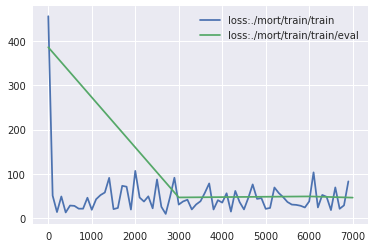

In [23]:
summary = Summary('./mort/train')
summary.plot('loss')

Let's run our model with the eval data to gather some metrics. Note that after training step was completed, two directories were created: "evaluation_model" and "model". The only difference between these two models is that "evaluation_model" takes input with target (or truth) column. This ensures that evaluation model is working properly, and output it as is. The "model" is already weighted because it has already been trained by our training data. 

In [24]:
!rm -r -f ./mort/batch_predict # Delete previous results.

In [25]:
%%ml batch_predict
model: ./mort/train/evaluation_model/
output: ./mort/evaluation
format: csv
data:
  csv: ./mort/eval.csv

local prediction...
INFO:tensorflow:Restoring parameters from ./mort/train/evaluation_model/variables/variables
done.


In [26]:
%%ml evaluate regression
csv: ./mort/evaluation/predict_results_eval.csv

,metric,value
0,Root Mean Square Error,6.756140
1,Mean Absolute Error,4.276313
2,50 Percentile Absolute Error,3.077465
3,90 Percentile Absolute Error,7.770266
4,99 Percentile Absolute Error,25.553772


In [27]:
%%ml evaluate accuracy
csv: ./mort/evaluation/predict_results_eval.csv

,accuracy,count,target
0,0.0,1,8.7
1,0.0,2,8.8
2,0.0,1,9.2
3,0.0,1,9.3
4,0.0,1,9.6
5,0.0,2,9.7
6,0.0,1,9.8
7,0.0,3,9.9
8,0.0,2,10
9,0.0,1,10.1


## Test on our three features (age, hcc score, charge)

we change the input data a little bit each time and see how our predicted value changes.

From the graph belowe, we can see that total charge does not have a significant impact on visits.Since people have different insurance plans and the variation between charge is very big, we find out that in real life, charge is also not a good predictor for hospital visits. However, change in age and especially change in hcc risk score can lead a significant change in visits. Because the older the patients are, the more likely they are less healthier and more likely they visit hopital more. Same for the hcc score, the larger the score, the less healthier the patients are--higher hcc score can lead to more hopital visits. Our model aligns to the real life!

In [28]:

%%ml predict
model: ./mort/train/model/
data:
  - 0.5, 30, 600
  - 0.5, 30, 15000
  - 0.5, 90, 600
  - 3.0, 90, 600  

predicted,age,average_hcc_score,total_charge
19.377941,30,0.5,600
19.377441,30,0.5,15000
19.469416,90,0.5,600
23.477806,90,3.0,600


In [29]:
df['age'].mean()

75.81455614776695

In [30]:
df['total_charge'].mean()

1685528.6968388164

## Utilize our predictive model in real life. 

In order to test the robustness and accuracy of our model in the real world, we estimated the age, hcc score, and the total charge from three relatives of the whole team.

The first row is the input of Angelina's grandmother. As her grandmother has diabetes, she has a higher hcc score. Moreover, since her grandmother is in China, which also means he has a lower healthcare cost. The total charge converted to US Dollar is just $5000. However, the predicted value for the total episodes visits is 19.48 which was approximately lower than the actural visits, 25. The reason behinds that might be since our dataset is collected from the United States Census in 2014, our model can not have a good prediction for an individual in China, especially the healthcare system is total different.

The second row is the input of Alisha's mother. As her mother lives in USA and healthier than Angelina's grandmother. Her hcc score is much lower than Angelina's grandmother but have a larger charge. Our model terns out to be more precise in this case, because the actural visits are around 15 and our predicted visits are 16.96. Our model did a grear job in this case!

The third row is the input of Kellen's grandfather. As his grandfather has a better insurance coverage, his total charge is $10,000. As a result, our model predicts that the total eposide visits are 17.8. Even though the actual visits are 20 and our model is little underestimated but it is pretty close.


In [31]:
%%ml predict
model: ./mort/train/model/
data:
  - 2.5, 74, 5000
  - 1.5, 48, 30000 
  - 2.0, 70, 10000
    

predicted,age,average_hcc_score,total_charge
18.794079,74,2.5,5000
17.810137,48,1.5,30000
17.450867,70,2.0,10000


# Limitation

We acknowledge that although our model does a farily great job for most of times, there are some limitations.

First, one of our limitation is that our original dataset only has 10882 observation. We might have the problem of overfitting by training 90% of our data.Second, since none of our features has a clear linear relationship with our output variable, visits, we might include some bias and inaccuracy into our model.Third, after we test on the real cases, we also found out that because the dataset is collected from U.S Census, our model is not accurate to predict observations from other countries.

# Conclusion

Overall, our exercise in machine learning produced a model that gave a fairly accurate prediction of the number of hospital visits on the bases of age, average HCC score, and total charge. By training our model to assign the appropriate weights to each factor, we were able to obtain a standard error of 6.6 visits. The effectiveness of this simple model is a demonstration of the powerful possibilities that machine learning models have to offer to both the healthcare industry and applications well beyond. 


# Citation
https://www.cdc.gov/reproductivehealth/maternalinfanthealth/infantmortality.htm